# **Klasifikasi MRI Autisme ResNet-50**
Gambar Nifti diubah ke 2D, RGB, Cross validation, Dropout


#### Import nibabel package to read NIfTI images

In [1]:
import keras
import numpy as np
import nibabel as nib
import tensorflow as tf
from keras import applications

#### Import all the keras required library

In [2]:
import os
from keras import layers
from google.colab import drive
import matplotlib.pyplot as plt
from keras.models import Sequential, Model 
from keras.losses import categorical_crossentropy
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

#### Fatch all the preprocessed images from the folder, preprocessing is done in SPM (matlab)

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Set path to folder containing NIfTI files
folder_path_autism = "/content/drive/MyDrive/Dataset_Autis/Autism"
folder_path_control = "/content/drive/MyDrive/Dataset_Autis/Control"

# daftar file .nii.gz dari folder1
files1 = [os.path.join(folder_path_autism, f) for f in os.listdir(folder_path_autism) if f.endswith('.nii.gz')]

# daftar file .nii.gz dari folder2
files2 = [os.path.join(folder_path_control, f) for f in os.listdir(folder_path_control) if f.endswith('.nii.gz')]

# Load images from the two folders
images1 = [nib.load(f) for f in files1]
images2 = [nib.load(f) for f in files2]

Mounted at /content/drive


In [4]:
# Combine the two sets of images
dataf = images1 + images2

# Generate labels for the images
labels = [1] * len(images1) + [0] * len(images2)

#### Data Conversion from 3D to 2D and introduce 3 channels (RGB) because the predefined model always takes 2D images with 3 channels in Keras.

In [5]:
# create an empty list to store the slice data
slice_list = []

# loop over the images and convert to 2D
for img in images1 + images2:
    # get the image data as a numpy array
    data = img.get_fdata()
    # select a slice to display (e.g. the middle slice along the first axis)
    slice_idx = data.shape[0] // 2
    # extract the 2D slice data
    slice_data = data[slice_idx, :, :]
    # add the slice data to the list
    slice_list.append(slice_data)

In [6]:
len(slice_list)

1102

In [7]:
data_array = np.array(slice_list)

In [8]:
data_array.shape

(1102, 73, 61)

#Turn to RGB

In [9]:
data_image=np.stack([data_array]*3, axis=-1)

In [10]:
data_image.shape

(1102, 73, 61, 3)

#### Split the data into train and test in the 70:30 ratio.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data_image, labels, test_size=0.2)
y_train=np.array(y_train)


input_shape = (73, 61,3)
x_train = x_train.astype('float32')
y_train = keras.utils.to_categorical(y_train)
y_old_test=y_test
y_test = keras.utils.to_categorical(y_test)


#### Use the ResNet50 model. 

In [12]:
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Add a dropout layer with dropout rate of 0.5
predictions = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 1s 0us/step


In [13]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 61, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 79, 67, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 37, 31, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 37, 31, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

#### Compile and train the model with Adam optimizer

In [14]:
# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [15]:
# Split data into K=5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with K-fold cross validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
    print(f'Fold {fold+1} Training ------------')
    x_train_fold = x_train[train_idx]
    y_train_fold = y_train[train_idx]
    x_val_fold = x_train[val_idx]
    y_val_fold = y_train[val_idx]

    history = model.fit(x_train_fold, y_train_fold, batch_size=100, epochs=40, validation_data=(x_val_fold, y_val_fold), callbacks=[early_stop])

    print(f"Fold {fold+1} Validation Accuracy: {np.mean(history.history['val_accuracy']):.4f}")

Fold 1 Training ------------


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
8/8 [==============================] - 25s 2s/step - loss: 1.0876 - accuracy: 0.5000 - val_loss: 0.8569 - val_accuracy: 0.5028
Epoch 2/40
8/8 [==============================] - 15s 2s/step - loss: 0.9246 - accuracy: 0.5014 - val_loss: 0.7423 - val_accuracy: 0.5028
Epoch 3/40
8/8 [==============================] - 18s 2s/step - loss: 0.8633 - accuracy: 0.4929 - val_loss: 0.7033 - val_accuracy: 0.5085
Epoch 4/40
8/8 [==============================] - 18s 2s/step - loss: 0.8598 - accuracy: 0.4773 - val_loss: 0.7002 - val_accuracy: 0.4689
Epoch 5/40
8/8 [==============================] - 16s 2s/step - loss: 0.8431 - accuracy: 0.4844 - val_loss: 0.7029 - val_accuracy: 0.4520
Epoch 6/40
8/8 [==============================] - 18s 2s/step - loss: 0.8008 - accuracy: 0.5057 - val_loss: 0.7032 - val_accuracy: 0.4576
Epoch 7/40
8/8 [==============================] - 15s 2s/step - loss: 0.8681 - accuracy: 0.4602 - val_loss: 0.7013 - val_accuracy: 0.4633
Epoch 8/40
8/8 [==================

#### The model loss and accuracy on test data. 

In [17]:
#x_test = X_test.reshape(X_test.shape[0],145,121,3)
x_test = x_test.astype('float32')
    # Normalizing the RGB codes by dividing it to the max RGB value.
print('Number of images in x_test', x_test.shape[0])
model.evaluate(x_test,y_test)


Number of images in x_test 221
7/7 [==============================] - 5s 809ms/step - loss: 0.6925 - accuracy: 0.5294


[0.6925139427185059, 0.529411792755127]

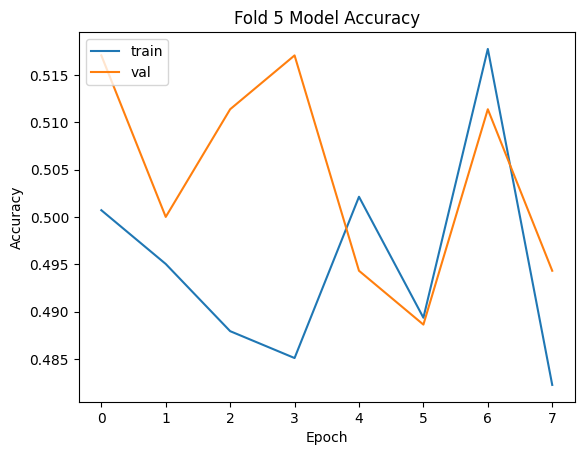

In [18]:
# Plot the training and validation accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Fold {fold+1} Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()